In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
drivers_df = pd.read_csv('datasets/drivers.csv')
drivers_code_df = drivers_df.drop(columns=['driverRef', 'number', 'forename', 'surname', 'dob', 'nationality', 'url'])

# Formula 1 changed its points system in 2010
years = list(range(2010, 2025))

races_df = pd.read_csv('datasets/races.csv')
races_df.drop(columns = ['date','time','url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time','sprint_date','sprint_time'], inplace=True)

driver_standings_df = pd.read_csv('datasets/driver_standings.csv')
driver_standings_df = pd.merge(driver_standings_df, drivers_code_df, on='driverId')
driver_standings_df

,driverStandingsId,raceId,driverId,points,position,positionText,wins,code
0,1,18,1,10.0,1,1,1,HAM
1,2,18,2,8.0,2,2,0,HEI
2,3,18,3,6.0,3,3,0,ROS
3,4,18,4,5.0,4,4,0,ALO
4,5,18,5,4.0,5,5,0,KOV
...,...,...,...,...,...,...,...,...
34590,72867,1132,839,3.0,18,18,0,OCO
34591,72868,1132,842,6.0,15,15,0,GAS
34592,72869,1132,822,0.0,21,21,0,BOT
34593,72870,1132,858,0.0,20,20,0,SAR


In [3]:
post_2010_races_df = races_df[races_df['year'].isin(years)]
post_2010_races_ids_df = post_2010_races_df['raceId']

post_2010_standings_df = driver_standings_df[driver_standings_df['raceId'].isin(post_2010_races_ids_df)]


post_2010_standings_df = pd.merge(post_2010_standings_df, post_2010_races_df, on='raceId')


time_series_data_df = post_2010_standings_df.copy()
time_series_data_df.drop(
    columns=['driverStandingsId', 'position', 'positionText', 'wins', 'circuitId', 'name'], 
    inplace=True)

time_series_data_df = time_series_data_df[time_series_data_df['year'] == 2024]
time_series_data_df.drop(columns=['year', 'raceId', 'driverId'], inplace=True)
time_series_data_df

# plt.figure(figsize=(10, 6))
# for driver, group in time_series_data_df.groupby('driverId'):
#     plt.plot(group['round'], group['points'], marker='o', label=driver)

# # Customize the plot
# plt.title('Cumulative Points per Round', fontsize=16)
# plt.xlabel('Round', fontsize=14)
# plt.ylabel('Points', fontsize=14)
# # plt.legend(title='Driver', fontsize=12)
# plt.grid(True)
# plt.show()

,points,code,round
6229,0.0,OCO,1
6230,0.0,HUL,1
6231,0.0,ALB,1
6232,0.0,TSU,1
6233,0.0,RIC,1
...,...,...,...
6475,3.0,OCO,12
6476,6.0,GAS,12
6477,0.0,BOT,12
6478,0.0,SAR,12


c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\astal\AppData\Local\Programs\Python\Python312\Lib

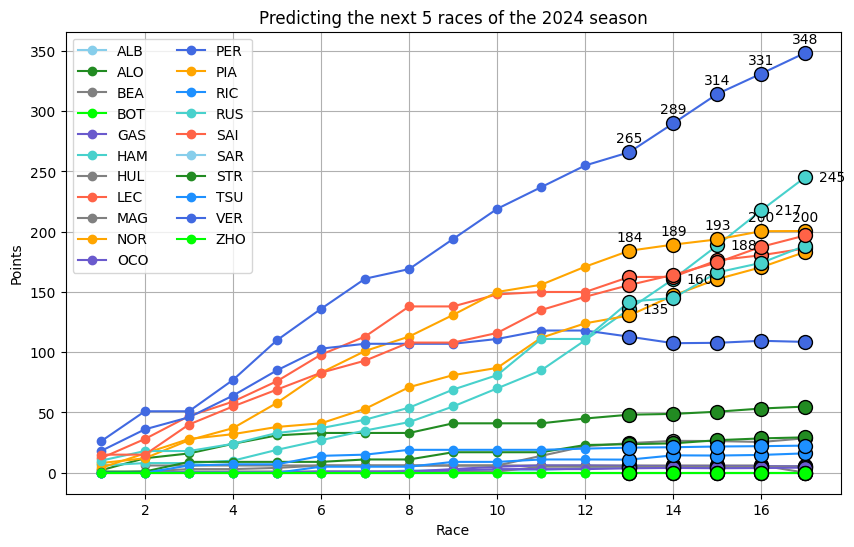

In [9]:
from statsmodels.tsa.arima.model import ARIMA

points_ts = time_series_data_df.pivot(index='round', columns='code', values='points')

forecasts = {}
for driver_id in points_ts.columns:
    driver_points = points_ts[driver_id].dropna()  # Drop missing values
    model = ARIMA(driver_points, order=(5, 1, 0))  # ARIMA parameters (p, d, q)
    model_fit = model.fit()
    
    # Forecast for the next 2 races
    forecasts[driver_id] = model_fit.forecast(steps=5)

# Combine forecasts into a DataFrame
forecast_df = pd.DataFrame(forecasts)
forecast_df.drop(index=forecast_df.index[0], axis=0, inplace=True)


forecast_df.index = range(points_ts.index[-1] + 1, points_ts.index[-1] + 6)
forecast_df = forecast_df.fillna(0)  # Handle missing forecasts


final_points = pd.concat([points_ts, forecast_df], axis=0)
final_points

drivers_to_highlight = ['VER', 'NOR', 'HAM']
driver_colors = {
    'VER': 'royalblue',
    'PER': 'royalblue',
    'PIA': 'orange',
    'NOR': 'orange',
    'HAM': 'mediumturquoise',
    'RUS': 'mediumturquoise',
    'LEC': 'tomato',
    'SAI': 'tomato',
    'ALO': 'forestgreen',
    'STR': 'forestgreen',
    'GAS': 'slateblue',
    'OCO': 'slateblue',
    'RIC': 'dodgerblue',
    'TSU': 'dodgerblue',
    'ZHO': 'lime',
    'BOT': 'lime',
    'MAG': 'grey',
    'BEA': 'grey',
    'HUL': 'grey',
    'ALB': 'skyblue',
    'SAR': 'skyblue'
}
# Plot cumulative points for each driver
plt.figure(figsize=(10, 6))


# Plot each driver's cumulative points
for driver in final_points.columns:
    line, = plt.plot(final_points.index, final_points[driver], marker='o', label=driver, color=driver_colors[driver])

# Highlight the last two races
last_two_races = final_points.iloc[-2:]  # Get the last two rows
for raceId in forecast_df.index:
    for driver in final_points.columns:
        plt.scatter(
            raceId, forecast_df.loc[raceId, driver],
            color=driver_colors[driver],  # Use the same color as the line
            edgecolor='black', s=100, zorder=5
        )
        if driver in drivers_to_highlight:
            if driver == 'HAM':
                plt.text(
                raceId + 0.3, forecast_df.loc[raceId, driver] ,  # Offset text slightly above the point
                f"{int(forecast_df.loc[raceId, driver])}",
                color='black', fontsize=10, va='center'
            )
            
            else: 
                plt.text(
                raceId, forecast_df.loc[raceId, driver] + 8,  # Offset text slightly above the point
                f"{int(forecast_df.loc[raceId, driver])}",
                color='black', fontsize=10, ha='center'
            )

plt.xlabel("Race")
plt.ylabel("Points")
plt.title("Predicting the next 5 races of the 2024 season")
plt.legend(loc='upper left', ncols=2)
plt.grid()
plt.show()